<img src='../../img/dust_banner.png' alt='Training school and workshop on dust' align='center' width='100%'></img>

<br>

# C3S Aerosol Properties Gridded Data - Level 3

### About

This notebooks provides an introduction to the [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview) and shows you how the variable `Dust Aerosol Optical Depth` can be used to monitor and predict dust events.

According to C3S, "This data set provides observational records of aerosol properties obtained from observations collected by various satellite instruments. 

The main variables provided by this dataset are: aerosol optical depth, fine mode aerosol optical depth, dust aerosol optical depth, single scattering albedo, aerosol layer height and aerosol extinction coefficient. These variables are derived from observations from several sensors using a set of different processing techniques. 

Selected observational records in this dataset are extended in time on a semi-annual basis. At the moment of extending, these records are up-to-date until five months behind present time." ([Source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview))

The notebook examines the **Saharan Dust event** which occured over Europe at the beginning of February 2021.


### Basic Facts

> **Spatial resolution**: `2.5° x 2.5° for aerosol extinction coefficient, 1° x 1° for all other variables` <br>
> **Spatial coverage**: `Global` <br>
> **Temporal resolution**:  `5-daily composite for the aerosol extinction coefficient, Daily and monthly for all other variables` <br>
> **Temporal coverage**: `since June 1995 to present with five month delay` <br>
> **Data format**: `NetCDF (compressed either as a zip or tar file)`


### How to access the data

C3S aerosol properties gridded data are available for download via the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/). You will need to create a CDS account [here](https://cds.climate.copernicus.eu/user/register).

Data from the CDS can be downloaded in two ways:
* `manually` via the [CDS web interface](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
* `programmatically` with a Python package called cdsapi ([more information](https://cds.climate.copernicus.eu/api-how-to))

### Module outline
* [*Optional: Retrieve C3S aerosol properties gridded data programmatically*](#c3s_cdsapi)
* [1 - Load and browse dust aerosol optical depth (duaod) at 550nm of the CAMS global near-real-time forecast](#load_browse_c3s_aerosol)
* [2 - Retrieve the time coordinate information and assign time coordinates for the time dimension](#assign_time_coord_c3s_aerosol)
* [3 - Retrieve the data variable dust AOD at 550nm as xarray.DataArray](#data_retrieve_c3s_aerosol)
* [4 - Visualize dust AOD at 550nm](#visualize_c3s_aerosol)
* [5 - Create a geographical subset for Europe](#subset_c3s_aerosol)
* [6 - Animate dust AOD at 550nm changes over time](#animate_c3s_aerosol)

<hr>

#### Load required libraries

In [1]:
import xarray as xr
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
from matplotlib.axes import Axes

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from IPython.display import HTML

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

### <a id='c3s_cdsapi'></a>*Optional: Retrieve C3S aerosol properties gridded data programmatically*

The `CDS Application Program Interface (CDS API)` is a Python library which allows you to access data from the CDS `programmatically`. In order to use the CDS API, follow the steps below:

* [Self-register](https://cds.climate.copernicus.eu/#!/home) at the CDS registration page (if you do not have an account yet)
* [Login](https://cds.climate.copernicus.eu/user/login) to the CDS portal and go to the [api-how-to page](https://cds.climate.copernicus.eu/api-how-to)
* Copy the CDS API key displayed in the black terminal window and replace the `######` of the `KEY` variable below with your individual CDS API key

**Note:** You find your CDS API key displayed in the black terminal box under the section `Install the CDS API key`. If you do not see a URL or key appear in the black terminal box, please refresh your browser tab. 

In [3]:
URL='https://cds.climate.copernicus.eu/api/v2'
KEY='#########################'

<br>

The next step is then to request the data with a so called `API request`. Via the [CDS web interface](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=form), you can select the data and at the end of the web interface, you can open the CDS request via `Show API request`. Copy the request displayed there in the cell below. Once you execute the cell, the download of the data starts automatically. Note that the code cell below is commented out. You need to delete the `'''` blockquotes to uncomment it for the cell to run.

In [4]:
'''

import cdsapi

c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'satellite-aerosol-properties',
    {
        'format': 'zip',
        'time_aggregation': 'daily_average',
        'variable': 'dust_aerosol_optical_depth',
        'sensor_on_satellite': 'iasi_on_metopb',
        'algorithm': 'ulb',
        'year': '2021',
        'month': '02',
        'day': [
            '04', '05', '06',
            '07', '08',
        ],
        'version': 'v9',
        'orbit': 'ascending',
    },
    './download.zip')

'''

"\n\nimport cdsapi\n\nc = cdsapi.Client(url=URL, key=KEY)\n\nc.retrieve(\n    'satellite-aerosol-properties',\n    {\n        'format': 'zip',\n        'time_aggregation': 'daily_average',\n        'variable': 'dust_aerosol_optical_depth',\n        'sensor_on_satellite': 'iasi_on_metopb',\n        'algorithm': 'ulb',\n        'year': '2021',\n        'month': '02',\n        'day': [\n            '04', '05', '06',\n            '07', '08',\n        ],\n        'version': 'v9',\n        'orbit': 'ascending',\n    },\n    './download.zip')\n\n"

<br>

C3S aerosol properties gridded data can be retrieved in a `zipped NetCDF` or a `tar-compressed NetCDF`. Above, we requested the data in a zipped NetCDF and for this reason, we have to unzip the file before we can open it. You can unzip `zip archives` in Python with the Python package `zipfile` and the function `extractall()`. You will see a five new files appearing in the same folder as this notebook. This is just for demonstration purposes.

In [5]:
import zipfile
with zipfile.ZipFile('../../../eodata/dust/part1/1_satellite/iasi_c3s/2021/02/download.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

<br>

### <a id='load_browse_c3s_aerosol'></a>1. Load and browse C3S aerosol properties gridded data

C3S aerosol properties gridded data is available as `netCDF`. 

The xarray `open_mfdataset()` function allows the opening of multiple files at once. You have to specify the dimension the files shall be concatenated by. It can be an existing dimension within the data file or a new dimension, which is newly specified.

Let us open the daily gridded aerosol properties data from C3S Metop-B IASI for the 5 days from 4 to 8 February 2021. We specify `time` as a new dimension that the data files shall be concatenated by. After you loaded the multiple files in a `Dataset` with the function `open_mfdataset()`, you have to select `absorbing_aerosol_index` again as the variable of interest.

The resulting `xarray.DataArray` has three dimensions (`time`, `latitude` and `longitude`).


In [6]:
file = xr.open_mfdataset('../../../eodata/dust/part1/1_satellite/iasi_c3s/2021/02/*C3S-L3_AEROSOL-AER_PRODUCTS-IASI-METOPB-ULB-DAILY-v9AN.nc', 
                         concat_dim='time', 
                         combine='nested')
file

<xarray.Dataset>
Dimensions:                      (latitude: 180, longitude: 360, time: 5)
Coordinates:
  * latitude                     (latitude) float64 -89.5 -88.5 ... 88.5 89.5
  * longitude                    (longitude) float64 -179.5 -178.5 ... 179.5
Dimensions without coordinates: time
Data variables:
    number                       (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    D_AOD10000_mean              (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    D_AOD10000_uncertainty_mean  (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    D_AOD11000_mean              (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    D_AOD550_mean                (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Detection_mean               (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/43)
    Title:                      Dust Aerosol Optical Depth retrieved from IAS...
    Institution:                Universite Libre de Bruxelles (ULB)
    Source:                     IASI L1C, IASI L2 NRT (EUMETSAT)
    History:                    2022-05-14 11:00:31 - Product generated from ...
    References:                 ULBNN ATBD issue 1.1
    Tracking_id:                8572ebff-3b19-4f81-9264-7e7c5df8a7a7
    ...                         ...
    dateTime:                   0051-02-03 00:00:00
    productID:                  20210204-C3S-L3_AEROSOL-D_AOD-IASI-MetopB-ULB...
    platform:                   MetOpA
    sensor:                     IASI
    spatial_resolution:         12 km diameter pixel at nadir
    inputFileList:              , g:\dust\v00009\Data\L2\2021\20210204-C3S-L2...

<br>

The data above has three dimensions (`latitude`, `longitude`, `time`) and several data variables. The data variable of interest is:
* `D_AOD550_mean`: Dust Aerosol Optical Depth at 550nm

Let us inspect the coordinates of the file more in detail.

The latitude values have a 1 degree resolution and have a global N-S coverage.

In [7]:
file.latitude

<xarray.DataArray 'latitude' (latitude: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,
        50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
        60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5])
Coordinates:
  * latitude  (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north
    valid_range:    [-90.  90.]

The longitude values have a 1 degree resolution as well, and are disseminated in a [0, 360] grid. 

In [8]:
file.longitude

<xarray.DataArray 'longitude' (longitude: 360)>
array([-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5])
Coordinates:
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east
    valid_range:    [-180.  180.]

## <a id='assign_time_coord_c3s_aerosol'></a>2. Retrieve  time coordinate information and assign time coordinates for the time dimension

By inspecting the metadata of the single data file `file` we loaded at the beginning, you can see that the metadata attribute `id` contains the date in the name.

The first step is to retrieve the metadata attribute `id` and to split the resulting string object at the positions with a dash `-`. The day string is the first position of the resulting string.

In [9]:
start_day = file.id.split('-')[0]
start_day

'20210204'

With the help of the Python library `pandas`, you can build a `DateTime` time series for the five consecutive days, starting from the `start_day` variable that was defined above.

You can use the `date_range` function from pandas, using the length of the time dimension of the `file` DataArray and `'d'` (for day) as freqency argument.

The result is a time-series with `DateTime` information from 4 to 8 February 2021.

In [10]:
time_coords = pd.date_range(datetime.strptime(start_day,'%Y%m%d'), periods=len(file.time), freq='d').strftime("%Y-%m-%d").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07',
               '2021-02-08'],
              dtype='datetime64[ns]', freq=None)

<br>

The final step is to assign the pandas time series object `time_coords` to the `file` DataArray object. You can use the `assign_coords()` function from xarray.

The result is that the time coordinates have now been assigned values. The only dimension the remains unassigned is `satellite`.

In [11]:
file = file.assign_coords(time=time_coords)
file

<xarray.Dataset>
Dimensions:                      (latitude: 180, longitude: 360, time: 5)
Coordinates:
  * latitude                     (latitude) float64 -89.5 -88.5 ... 88.5 89.5
  * longitude                    (longitude) float64 -179.5 -178.5 ... 179.5
  * time                         (time) datetime64[ns] 2021-02-04 ... 2021-02-08
Data variables:
    number                       (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    D_AOD10000_mean              (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    D_AOD10000_uncertainty_mean  (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    D_AOD11000_mean              (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    D_AOD550_mean                (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Detection_mean               (time, latitude, longitude) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/43)
    Title:                      Dust Aerosol Optical Depth retrieved from IAS...
    Institution:                Universite Libre de Bruxelles (ULB)
    Source:                     IASI L1C, IASI L2 NRT (EUMETSAT)
    History:                    2022-05-14 11:00:31 - Product generated from ...
    References:                 ULBNN ATBD issue 1.1
    Tracking_id:                8572ebff-3b19-4f81-9264-7e7c5df8a7a7
    ...                         ...
    dateTime:                   0051-02-03 00:00:00
    productID:                  20210204-C3S-L3_AEROSOL-D_AOD-IASI-MetopB-ULB...
    platform:                   MetOpA
    sensor:                     IASI
    spatial_resolution:         12 km diameter pixel at nadir
    inputFileList:              , g:\dust\v00009\Data\L2\2021\20210204-C3S-L2...

<br>

### <a id='data_retrieve_c3s_aerosol'></a>3. Retrieve the variable *Dust Aerosol Optical Depth at 550nm* as data array

Let us extract from the dataset above the data variable `Dust Aerosol Optical Depth (AOD) at 550nm` as `xarray.DataArray` with the name `du_aod`. You can load a data array from a xarray dataset by specifying the name of the variable (`D_AOD550_mean`) in square brackets.

In [12]:
du_aod = file['D_AOD550_mean']
du_aod

<xarray.DataArray 'D_AOD550_mean' (time: 5, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(5, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) datetime64[ns] 2021-02-04 2021-02-05 ... 2021-02-08
Attributes:
    long_name:      Dust Aerosol Optical Depth at 550 nm
    standard_name:  atmosphere_optical_thickness_due_to_aerosol
    units:          1
    valid_range:    [ 0. inf]

Next, we can fill all `NaN` values with a large negative number to prevent the piling up of pixels in our animation later on. We will use a colormap later that has a white color for values at or below 0.

In [13]:
du_aod = du_aod.fillna(-999)

Above, you see that the variable `du_aod` has an attribute called `long_name`. Let us define variables for this attribute so it can be used later for visualizing the data.

In [14]:
long_name = du_aod.long_name

Let us do the same for the coordinates `longitude` and `latitude`.

In [15]:
latitude = du_aod.latitude
longitude = du_aod.longitude

<br>

### <a id='visualize_c3s_aerosol'></a>4. Visualize *Dust Aerosol Optical Depth at 550nm*

The next step is to visualize the dataset. You can use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh), which makes use of matploblib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

With `?visualize_pcolormesh` you can open the function's docstring to see what keyword arguments are needed to prepare your plot.

In [16]:
?visualize_pcolormesh

Signature:
visualize_pcolormesh(
    data_array,
    longitude,
    latitude,
    projection,
    color_scale,
    unit,
    long_name,
    vmin,
    vmax,
    set_global=True,
    lonmin=-180,
    lonmax=180,
    latmin=-90,
    latmax=90,
)
Docstring:
Visualizes a xarray.DataArray with matplotlib's pcolormesh function.

Parameters:
    data_array(xarray.DataArray): xarray.DataArray holding the data values
    longitude(xarray.DataArray): xarray.DataArray holding the longitude values
    latitude(xarray.DataArray): xarray.DataArray holding the latitude values
    projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
    color_scale(str): string taken from matplotlib's color ramp reference
    unit(str): the unit of the parameter, taken from the NetCDF file if possible
    long_name(str): long name of the parameter, taken from the NetCDF file if possible
    vmin(int): minimum number on visualisation legend
    vmax(int): maximum number on visualisation

You can make use of the variables we defined above:
- `units`
- `long_name`
- `latitude`
- `longitude`

Additionally, you can specify the `color scale` and minimum (`vmin`) and maxium (`vmax`) data values.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Dust Aerosol Optical Depth at 550 nm 2021-02-06'}>)

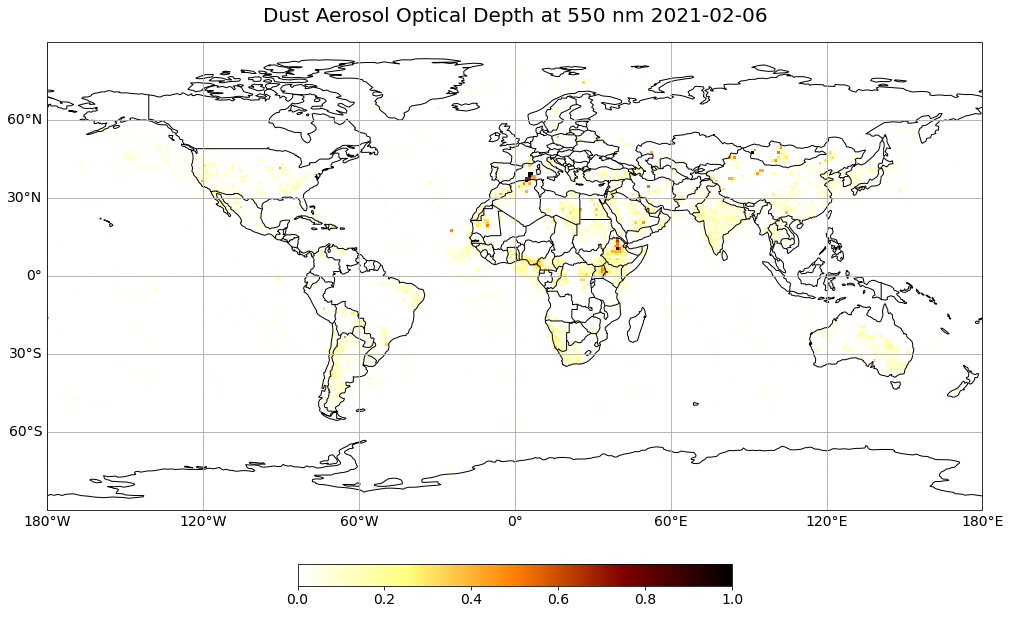

In [17]:
time_index = 2
visualize_pcolormesh(data_array=du_aod[time_index,:,:],
                     longitude=longitude,
                     latitude=latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='afmhot_r',
                     unit=' ',
                     long_name=long_name + ' ' + str(du_aod[time_index,:,:].time.data)[0:10],
                     vmin=0, 
                     vmax=1)

<br>

### <a id='subset_c3s_aerosol'></a>5. Create a geographical subset for Europe

The map above shows Dust Aerosol Optical Depth at 550nm globally. Let us create a geographical subset for Europe, in order to better analyse the Saharan dust event which impacts parts of central and southern Europe.

For geographical subsetting, you can use the function [generate_geographical_subset](../functions.ipynb#generate_geographical_subset). You can use `?generate_geographical_subset` to open the docstring in order to see the function's keyword arguments.

In [18]:
?generate_geographical_subset

Signature:
generate_geographical_subset(
    xarray,
    latmin,
    latmax,
    lonmin,
    lonmax,
    reassign=False,
)
Docstring:
Generates a geographical subset of a xarray.DataArray and if kwarg reassign=True, shifts the longitude grid 
from a 0-360 to a -180 to 180 deg grid.

Parameters:
    xarray(xarray.DataArray): a xarray DataArray with latitude and longitude coordinates
    latmin, latmax, lonmin, lonmax(int): lat/lon boundaries of the geographical subset
    reassign(boolean): default is False
    
Returns:
    Geographical subset of a xarray.DataArray.
File:      /tmp/ipykernel_1451/3979307327.py
Type:      function


Define the bounding box information for Europe

In [19]:
latmin = 28.
latmax = 71.
lonmin = -22.
lonmax = 43

Now, let us apply the function [generate_geographical_subset](../functions.ipynb#generate_geographcial_subset) to subset the `du_aod` xarray.DataArray. Let us call the new `xarray.DataArray` `du_aod_subset`.

In [20]:
du_aod_subset = generate_geographical_subset(xarray=du_aod, 
                                             latmin=latmin, 
                                             latmax=latmax, 
                                             lonmin=lonmin, 
                                             lonmax=lonmax)
du_aod_subset

<xarray.DataArray 'D_AOD550_mean' (time: 5, latitude: 43, longitude: 65)>
dask.array<where, shape=(5, 43, 65), dtype=float64, chunksize=(1, 43, 65), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 28.5 29.5 30.5 31.5 ... 67.5 68.5 69.5 70.5
  * longitude  (longitude) float64 -21.5 -20.5 -19.5 -18.5 ... 40.5 41.5 42.5
  * time       (time) datetime64[ns] 2021-02-04 2021-02-05 ... 2021-02-08
Attributes:
    long_name:      Dust Aerosol Optical Depth at 550 nm
    standard_name:  atmosphere_optical_thickness_due_to_aerosol
    units:          1
    valid_range:    [ 0. inf]

Let us visualize the subsetted `xarray.DataArray` again. This time, you set the `set_global` kwarg to `False` and you specify the longitude and latitude bounds specified above.

Additionally, in order to have the time information as part of the title, we add the string of the datetime information to the `long_name` variable: `long_name + ' ' + str(du_aod_subset[##,:,:].time.data)[0:10]`.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Dust Aerosol Optical Depth at 550 nm 2021-02-06'}>)

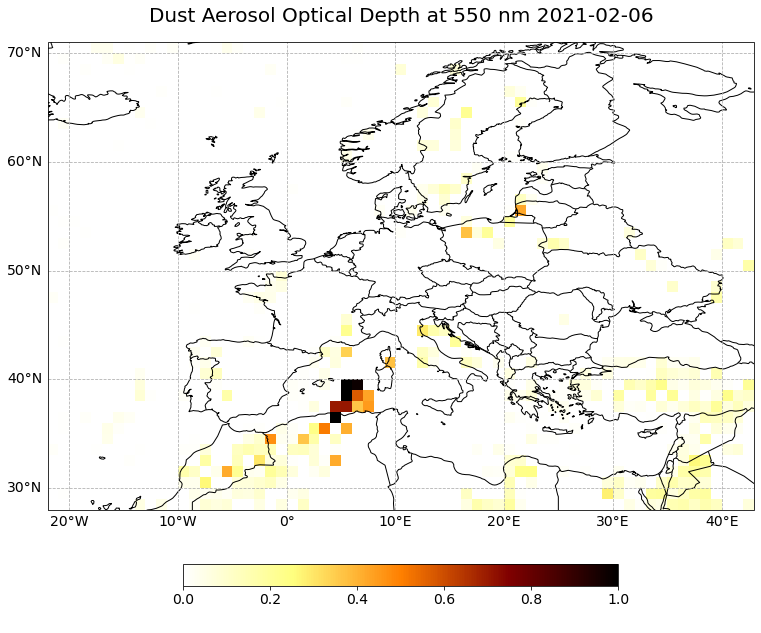

In [21]:
time_index = 2
visualize_pcolormesh(data_array=du_aod_subset[time_index,:,:],
                     longitude=du_aod_subset.longitude,
                     latitude=du_aod_subset.latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='afmhot_r',
                     unit=' ',
                     long_name=long_name + ' ' + str(du_aod_subset[time_index,:,:].time.data)[0:10],
                     vmin=0, 
                     vmax=1,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

<br>

### <a id='animate_c3s_aerosol'></a>6. Animate changes of *Dust Aerosol Optical Depth at 550nm* over time

In the last step, you can animate the `Dust Aerosol Optical Depth at 550nm` in order to see how the trace gas develops over a period of 5 days, from 4th to 8th February 2021.

You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [22]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=du_aod_subset[0,:,:],
                               longitude=du_aod_subset.longitude, 
                               latitude=du_aod_subset.latitude,
                               projection=ccrs.PlateCarree(), 
                               color_scale='afmhot_r', 
                               unit=' ',
                               long_name=long_name + ' '+ str(du_aod_subset.time[0].data)[0:10],
                               vmin=0,
                               vmax=1, 
                               lonmin=lonmin, 
                               lonmax=lonmax, 
                               latmin=latmin, 
                               latmax=latmax,
                               set_global=False)

frames = 5

def draw(i):
    img = plt.pcolormesh(du_aod_subset.longitude, 
                         du_aod_subset.latitude, 
                         du_aod_subset[i,:,:], 
                         cmap='afmhot_r', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=1,
                         shading='auto')
    
    ax.set_title(long_name + ' '+ str(du_aod_subset.time[i].data)[0:10], fontsize=20, pad=20.0)
    return img

def init():
    return fig

def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)

<br>

#### Play the animation video as HTML5 video

In [23]:
HTML(ani.to_html5_video())

<hr>

### References

* Copernicus Service information 2023
* Generated using Copernicus Atmosphere Monitoring Service Information 2023

<hr>

<img src='../../img/copernicus_logo.png' alt='Logo EU Copernicus' align='left' width='20%'><br><br><br><br>
This project is licensed under <a href="../../LICENSE">GNU General Public License v3.0 only</a> and is developed under a Copernicus contract.

<p style="text-align:right;"> <a href='https://training.eumetsat.int'>EUMETSAT Training</a> | <a href='mailto:training@eumetsat.int'>Contact the training team</a></p>